# European option pricing in the Heston model

In [5]:
from scipy.integrate import quad
import cmath
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
from scipy.optimize import bisect
from scipy.stats import norm


In [8]:
#### Black Sholes Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    F, DF = np.exp((r-d)*T)*S, np.exp(-r*T)
    vsq = v*np.sqrt(T)
    try:
        d1 = (np.log(F/X) + (0.5*vsq*vsq)) / vsq
    except:
        d1 = 0.
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))

In [9]:
def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm to compute the implied volatility
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True,S,K,T,r,0.,vol)
    vMin = 0.000001
    vMax = 10.0
    try:
        iv = bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), xtol=1e-20, rtol=1e-15, full_output=False, disp=True)
    except:
        iv = 0.
    return iv

## Numerical tests

In [13]:
hestonParams = 2.1, 0.05, 0.1, -0.99, 0.04
hestonParams2 = 2.1, 0.05, 0.1, -0.4, 0.05
r, s0, K, T = 0., 1., 0.5, 1.
xx = np.linspace(-1., 1., 20) ## range of log-moneyness

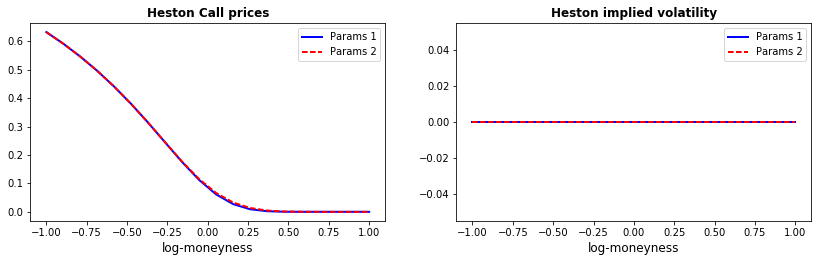

In [14]:
calls = [heston_EuropeanCall(hestonParams,r,T,s0,s0*np.exp(x)) for x in xx]
calls2 = [heston_EuropeanCall(hestonParams2,r,T,s0,s0*np.exp(x)) for x in xx]
ivs = [heston_Impliedvol(hestonParams,r,T,s0,s0*np.exp(x)) for x in xx]
ivs2 = [heston_Impliedvol(hestonParams2,r,T,s0,s0*np.exp(x)) for x in xx]

fig = plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.plot(xx, calls, 'b-', label="Params 1", linewidth=2)
plt.plot(xx, calls2, 'r--', label="Params 2", linewidth=2)
plt.title("Heston Call prices", fontsize=12, fontweight='bold')
plt.xlabel(u'log-moneyness', fontsize=12)
plt.legend(loc=1)

plt.subplot(2, 2, 2)
plt.plot(xx, ivs, 'b-', label="Params 1", linewidth=2)
plt.plot(xx, ivs2, 'r--', label="Params 2", linewidth=2)
plt.title("Heston implied volatility", fontsize=12, fontweight='bold')
plt.xlabel(u'log-moneyness', fontsize=12)
plt.legend(loc=1)
plt.show()

In [12]:
StrikeNum, MaturityNum = 20, 20
r, S0, alpha = 0.0, 1., 1.25
hestonParams = 2.1, 0.05, 0.1, -0.2, 0.04

XX = np.linspace(np.exp(-1.), np.exp(1.), StrikeNum)      ###Strikes
YY = np.linspace(0.5, 2., MaturityNum)    ###Maturities